# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 4 files that contain the dataset:


https://drive.google.com/open?id=1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh

https://drive.google.com/open?id=18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv

https://drive.google.com/open?id=1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz

https://drive.google.com/open?id=1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW3a')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh': 'hw3_mycocodata_bboxes_comp_zlib.npy',
'18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv': 'hw3_mycocodata_img_comp_zlib.h5',
'1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz': 'hw3_mycocodata_labels_comp_zlib.npy',
'1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a': 'hw3_mycocodata_mask_comp_zlib.h5',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

Mounted at /content/gdrive


In [0]:
import numpy as np
import h5py
import torch
import torchvision
from matplotlib import pyplot as plt
from pdb import set_trace as debug
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.ticker as plticker
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tnrange, tqdm_notebook
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [0]:
def mount_drive():
  DRIVE_MOUNT='/content/gdrive'
  drive.mount(DRIVE_MOUNT)


  # create folder to write data to
  CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
  HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW3a')
  os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

In [0]:
all_images_h5 = h5py.File('./hw3_mycocodata_img_comp_zlib.h5')
all_image_data = all_images_h5.get(f'{list(all_images_h5.keys())[0]}').value

all_mask_h5 = h5py.File('./hw3_mycocodata_mask_comp_zlib.h5')
all_mask_data = all_mask_h5.get(f'{list(all_mask_h5.keys())[0]}').value

all_bbox_data = np.load('./hw3_mycocodata_bboxes_comp_zlib.npy', allow_pickle=True)

all_label_data = np.load('./hw3_mycocodata_labels_comp_zlib.npy', allow_pickle=True)

In [0]:
np.random.seed(9)
torch.manual_seed(9)
permute_index = np.arange(len(all_image_data))
np.random.shuffle(permute_index)
train_N = int(len(all_image_data)*0.85)

train_ind, test_ind = permute_index[:train_N], permute_index[train_N:]

In [0]:
train_image = all_image_data[train_ind]
test_image = all_image_data[test_ind]

train_mask = all_mask_data[train_ind]
test_mask = all_mask_data[test_ind]

train_bbox = all_bbox_data[train_ind]
test_bbox = all_bbox_data[test_ind]

train_label = all_label_data[train_ind]
test_label = all_label_data[test_ind]

In [0]:
all_bbox_stack = np.concatenate(train_bbox, axis = 0)
class_stack = np.concatenate(train_label, axis = 0)

all_bbox_w = all_bbox_stack[:, 2] - all_bbox_stack[:, 0]
all_bbox_h = all_bbox_stack[:, 3] - all_bbox_stack[:, 1]
all_bbox_aspect = all_bbox_w / all_bbox_h
all_bbox_scale = all_bbox_w / 400

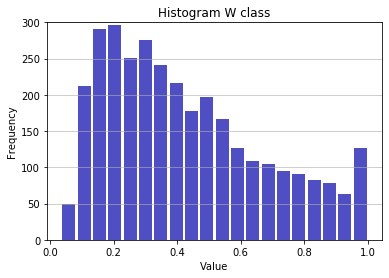

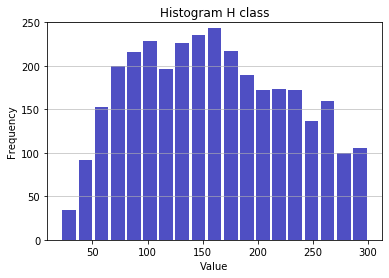

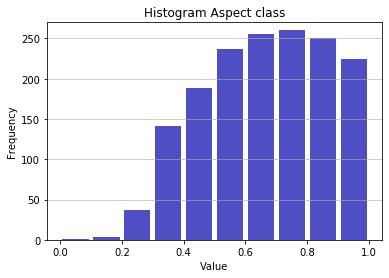

In [0]:
## Plot Histogram
histW,binsW = np.histogram(all_bbox_w)
histH,binsH = np.histogram(all_bbox_h)
histAs,binsAS = np.histogram(all_bbox_aspect) 


num_classes = 3
class_stack = np.concatenate(train_label, axis = 0)



class_bbox = class_stack
n, bins, patches = plt.hist(x=all_bbox_scale, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Histogram W class')

maxfreq = n.max()

plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig(f'../content/gdrive/My Drive/CIS680_2019/HW3a/Histogram_W.jpg')
plt.show()

n, bins, patches = plt.hist(x=all_bbox_h, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Histogram H class')

maxfreq = n.max()

# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig(f'../content/gdrive/My Drive/CIS680_2019/HW3a/Histogram_H.jpg')
plt.show()

n, bins, patches = plt.hist(x=all_bbox_aspect, bins=np.arange(0, 1.1, 0.1), color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f'Histogram Aspect class')

maxfreq = n.max()

plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.savefig(f'../content/gdrive/My Drive/CIS680_2019/HW3a/Histogram_aspect.jpg')
plt.show()

In [0]:
## Get Anchors

In [0]:
def get_anchors(Scale, Asp, lab):
  anchor_ar = np.zeros(2)
  # class_bbox = np.where(class_stack == i+1)[0]
  histW,binsW = np.histogram(Scale, bins = 'auto')
  histAs,binsAs = np.histogram(Asp, bins = 'auto')
  wAvg = (binsW[:-1] + binsW[1:]) / 2
  asAvg = (binsAs[:-1] + binsAs[1:]) / 2
  anchor_ar[0], anchor_ar[1] = wAvg[np.argmax(histW)], asAvg[np.argmax(histAs)]
  return anchor_ar

In [0]:
def IoU_func(box1, box2, min_clip = 0, max_clip = 127, debug_flag = False):
  if len(box1.shape) > 1:
    x1, y1, w1, h1 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
  else:
    x1, y1, w1, h1 = box1[0:4]
  if len(box2.shape) > 1:
    x2, y2, w2, h2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
  
  else:
    x2, y2, w2, h2 = box2[0:4]
    
  if debug_flag:
    debug()
    
  top_x1, bottom_x1, top_y1, bottom_y1 = x1 - w1/2.0, x1 + w1/2.0, y1 - h1/2.0, y1 + h1/2.0

  top_x2, bottom_x2, top_y2, bottom_y2 = x2 - w2/2.0, x2 + w2 /2.0, y2 - h2/2.0, y2 + h2/2.0
  
  xA, xB = np.maximum(top_x1, top_x2), np.minimum(bottom_x1, bottom_x2)
  
  yA, yB = np.maximum(top_y1, top_y2), np.minimum(bottom_y1, bottom_y2)
  
  interArea_x = np.maximum(0, xB - xA + 1) 
  interArea_y = np.maximum(0, yB - yA + 1)
  
  interArea = interArea_x*interArea_y
  boxAArea = (bottom_x1 - top_x1 + 1) * (bottom_y1 - top_y1 + 1)
  boxBArea = (bottom_x2 - top_x2 + 1) * (bottom_y2 - top_y2 + 1)
  if debug_flag:
    debug()
  
  iou = interArea / (boxAArea + boxBArea - interArea)
  
  if debug_flag:
    debug()
  
  return iou

In [0]:
def anchor_xywh(my_x, my_y, an_w, an_as, shape_factor = 1,step = 16):
  real_x, real_y = step*my_y + step/2, step*my_x + step/2

  if shape_factor > 1:
    real_w = np.repeat(an_w, len(real_x))
    real_h = np.repeat(an_w/an_as, len(real_x))

    return np.concatenate([real_x.reshape(-1, 1), real_y.reshape(-1, 1), real_w.reshape(-1, 1), real_h.reshape(-1, 1)], axis = 1)
  else:
    real_w = an_w
    real_h = an_w/an_as
    return np.array([real_x, real_y, real_w, real_h])

def true_xywh(truth):

  if len(truth.shape) > 1:
    x_cent, y_cent = (truth[:, 0] + truth[:, 2])/2, (truth[:, 1] + truth[:, 3])/2
    W, H = truth[:, 2] - truth[:, 0], truth[:, 3] - truth[:, 1]
    return np.concatenate([x_cent.reshape(-1, 1), y_cent.reshape(-1, 1), W.reshape(-1, 1), H.reshape(-1, 1)], axis = 1)

  else:
    x_cent, y_cent = (truth[0] + truth[2])/2, (truth[1] + truth[3])/2
    W, H = truth[2] - truth[0], truth[3] - truth[1]

    return np.array([x_cent, y_cent, W, H])


def format_labels(ini_labels, anchor_w, anchor_asp, true_label, 
                  n_classes = 3, step = 16.0, 
                  im_w = 400, im_h = 300, subSample = False):
  
  label_array = np.full([len(ini_labels), 18, 25, 8], -1)
  label_array[:, :, :, 1:] = 0
  anchor_w = anchor_w*im_w



  for i, cur_label in enumerate(ini_labels):

    lab1 = true_label[i]

    X, Y = np.where(label_array[i, :, :, 0] == -1)


    for j in range(len(cur_label)):
      anchorXYWH = anchor_xywh(X, Y, anchor_w, anchor_asp, shape_factor = len(X))

      label_vec = lab1[j].astype(int) - 1
      one_hot = np.eye(n_classes)[label_vec]

      trueXYWH = true_xywh(cur_label[j])


      IoU_anc = IoU_func(trueXYWH.reshape(1, -1), anchorXYWH, debug_flag=False)

      obj_index = np.where(IoU_anc > 0.7)[0]

      if len(obj_index) == 0:
        obj_index = np.where(np.around(IoU_anc, decimals=5) == np.max(np.around(IoU_anc, decimals=5)))


      one_indexX, one_indexY = X[obj_index], Y[obj_index]
      label_array[i, one_indexX, one_indexY, 0] = 1
      label_array[i, one_indexX, one_indexY, 1:5] = trueXYWH
      label_array[i, one_indexX, one_indexY, 5:] = one_hot



    X, Y = np.where(label_array[i, :, :, 0] != 1)
    anchorXYWH = anchor_xywh(X, Y, anchor_w, anchor_asp, shape_factor = len(X))
    zero_index = np.where((anchorXYWH[:, 0] - anchor_w/2 >= 0) & 
                              (anchorXYWH[:, 0] + anchor_w/2 <= im_w) & 
                              (anchorXYWH[:, 1] - (anchor_w/anchor_asp)/2 >= 0) &
                              (anchorXYWH[:, 1] + (anchor_w/anchor_asp)/2 <= im_h))[0]

    X, Y = X[zero_index], Y[zero_index]

    prev_mask_flag = None
    true_mask_flag = None
    for j in range(len(cur_label)):
      mask = np.zeros([18, 25])
      anchorXYWH = anchor_xywh(X, Y, anchor_w, anchor_asp, shape_factor = len(X))
      trueXYWH = true_xywh(cur_label[j])

      IoU_anc = IoU_func(trueXYWH, anchorXYWH)

      obj_index = np.where(IoU_anc < 0.3)[0]

      one_indexX, one_indexY = X[obj_index], Y[obj_index]
      mask[one_indexX, one_indexY] = 1
      if prev_mask_flag:
        true_mask = prev_mask*mask
        true_mask_flag = True

      prev_mask = mask
      prev_mask_flag = True
    if true_mask_flag:
      zero_x, zero_y = np.where(true_mask == 1)
    else:
      zero_x, zero_y = np.where(prev_mask == 1)
    label_array[i, zero_x, zero_y, 0] = 0

    if subSample:
      label_array[i, :, :, 0] = sub_sample(label_array[i, :, :, 0])
  
  return label_array

In [0]:
anchors = get_anchors(all_bbox_scale, all_bbox_aspect, class_stack)


In [0]:
rpn_labels_ = format_labels(train_bbox, anchors[0], anchors[1], train_label, subSample=False)

In [0]:

def my_collate(batch):

  data = [item[0].unsqueeze(0) for item in batch]
  target = [item[1] for item in batch]

  rpn = [item[2].unsqueeze(0) for item in batch]
  actual_bbox = [item[3] for item in batch]
  return [torch.cat(data), torch.cat(rpn), target, actual_bbox]
  
class HW3Dataset(torch.utils.data.Dataset):
  def __init__(self, image_file, label_file, bbox_file, mask_file,anchors_file,transform = None):
    assert isinstance(image_file, np.ndarray) and isinstance(image_file, np.ndarray), 'image_file and label_file should be of numpy array format'
    assert len(image_file) == len(label_file), 'images and labels are differnt sizes'
    
    
    self.images = image_file
    self.labels = label_file
    self.rpn_label = format_labels(bbox_file, anchors_file[0], anchors_file[1], label_file, subSample=False)
    self.actual_bbox = bbox_file
    self.mask = mask_file
    self.transform = transform
    
  def __len__(self):
    return len(self.images)
    
    
  def __getitem__(self, index):
    sample_image = self.images[index]
    sample_label = self.labels[index]
    sample_rpn = self.rpn_label[index]
    sample_actual_box = self.actual_bbox[index]

    
    if self.transform:
      sample_image = self.transform(torch.from_numpy(sample_image/255.0))
            
    return (sample_image, torch.from_numpy(sample_label), torch.from_numpy(sample_rpn), torch.from_numpy(sample_actual_box))
  

In [0]:
transform_ = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
dataset_train_hw3 = HW3Dataset(image_file = train_image, label_file =train_label,
                                bbox_file = train_bbox, mask_file = train_mask, 
                               anchors_file = anchors,
                         transform = transform_)

In [0]:
dataset_test_hw3 = HW3Dataset(image_file = test_image, label_file =test_label,
                                bbox_file = test_bbox, mask_file = test_mask, 
                               anchors_file = anchors,
                         transform = transform_)

In [0]:
dataloader_train_hw3 = DataLoader(dataset_train_hw3, batch_size=32,
                        shuffle=True, num_workers=4, collate_fn=my_collate)

In [0]:
dataloader_test_hw3 = DataLoader(dataset_test_hw3, batch_size=32,
                        shuffle=True, num_workers=4, collate_fn=my_collate)

# Dataset test



In [0]:
def pre_process_test(index, test_images, actual_labels, processed_labels,
                     anchor_w, anchor_asp,
                    step = 16, w_im = 400, h_im = 300, normalized = False):
  
  actual_label = actual_labels[index]
  processed_label = processed_labels[index]
  test_image = test_images[index]
  anchor_w = anchor_w*w_im
  print(len(processed_label[processed_label[:, :, 0] == 0]), len(processed_label[processed_label[:, :, 0] == 1]), len(processed_label[processed_label[:, :, 0] == -1]))
  
  if isinstance(test_image, torch.Tensor):
    if normalized:
      re_norm = transforms.Compose([transforms.Normalize(mean=[-1,-1,-1],std=[2,2,2])])
      test_image = re_norm(test_image).numpy()*255.0
    processed_label = processed_label.numpy()
      
  if len(test_image) <= 3:
    test_image = np.transpose(test_image, (1, 2, 0))
  
  ctest_image = test_image.copy()

  grid_color = -1

  
  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')

  ax = plt.gca()



  for i in range(len(actual_label)):


    rect = Rectangle((actual_label[i,0],actual_label[i,1]),
                     actual_label[i,2] - actual_label[i,0],
                     actual_label[i,3] - actual_label[i,1],
                     linewidth=2,edgecolor='r',facecolor='none'
                     )


    ax.add_patch(rect)


  ## Plot based on transformed image
  
  object_x, object_y = np.where(processed_label[:, :, 0] == 1)

  for i, (x,y) in enumerate(zip(object_x, object_y)):
    
    top_x, top_y = x*16 + step/2 -(anchor_w/anchor_asp)/2, y*16 + step/2 - anchor_w/2

    rect = Rectangle((top_y,top_x),
                     anchor_w, anchor_w/anchor_asp,
                     linewidth=2,edgecolor= 'b',
                     facecolor='none')

    ax.add_patch(rect)

  plt.savefig(f'../content/gdrive/My Drive/CIS680_2019/HW3a/test_preprocess.jpg')


  plt.show()

In [0]:
pre_process_test(2, train_image, train_bbox, rpn_labels_, anchors[0], anchors[1])

# Model Definition

In [0]:
class FasterRCNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
    self.pool = nn.MaxPool2d((2,2), stride=2, padding = 0)
    
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16,
                               kernel_size=5,
                               padding = (2,2))
    self.conv1_bn = nn.BatchNorm2d(16)
    
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32,
                               kernel_size=5,
                                padding = (2,2))
    self.conv2_bn = nn.BatchNorm2d(32)
    
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=5,
                               padding = (2,2))
    self.conv3_bn = nn.BatchNorm2d(64)
    
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=5,
                               padding = (2,2))
    self.conv4_bn = nn.BatchNorm2d(128)
    
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256,
                               kernel_size=5,
                               padding = (2,2))
    self.conv5_bn = nn.BatchNorm2d(256)
    
    self.conv_intermediate = nn.Conv2d(in_channels=256, out_channels=256,
                               kernel_size=3,
                               padding = (1,1))
    self.conv_intermediate_bn = nn.BatchNorm2d(256)
    
    
    self.conv_object = nn.Conv2d(in_channels=256, out_channels=1,
                               kernel_size=1)
    
    self.conv_region = nn.Conv2d(in_channels=256, out_channels=4,
                               kernel_size=1)
    
    
    
    
    
  def forward(self, x):
    
    out1 = self.pool(F.relu(self.conv1_bn(self.conv1(x))))

    out2 = self.pool(F.relu(self.conv2_bn(self.conv2(out1))))
    

    out3 = self.pool(F.relu(self.conv3_bn(self.conv3(out2))))
    out4 = self.pool(F.relu(self.conv4_bn(self.conv4(out3))))
    out5 = F.relu(self.conv5_bn(self.conv5(out4)))
    intermediate = F.relu(self.conv_intermediate_bn(self.conv_intermediate(out5)))
    out_object = torch.sigmoid(self.conv_object(intermediate))
    out_region = self.conv_region(intermediate)

    
    return out_object, out_region

# Train your network



In [0]:
def test(net, device,optimizer, criterion1, criterion2, test_loader, 
         anchor_w, anchor_asp):
  net.eval()
  with torch.no_grad():
      corr = 0
      total = 0
      test_loss = 0
      prec_epoch = 0
      rec_epoch = 0

      for i, (images_te, rpn_labels_te, labels_te, actual_boxes_te) in enumerate(test_loader):
      

          images_te = images_te.float().to(device)
          rpn_labels_te = rpn_labels_te.float().to(device)
          outputs_obj, outputs_region = net(images_te)
          loss_obj = bce_loss(outputs_obj, rpn_labels_te, criterion1)
          loss_reg = criterion2(outputs_region, rpn_labels_te, anchor_w, anchor_asp, device = device)

          preci, reca = calculate_precision_recall_object(outputs_obj, rpn_labels_te[:, :, :, 0])
          prec_epoch += preci.item()
          rec_epoch += reca.item()

  return prec_epoch / len(test_loader), rec_epoch / len(test_loader)

  
def fastrcnn_loss(X, rpn_label, anchor_w, anchor_asp, device):

  Xp = X.permute(0,2,3,1)
  ind_Z, ind_X, ind_Y = torch.where(rpn_label[:, :, :, 0] == 1)

  x = Xp[ind_Z, ind_X, ind_Y, :]
  x_a = anchor_xywh(ind_X.cpu(), ind_Y.cpu(), anchor_w, anchor_asp, shape_factor = len(X))

  x_a = torch.from_numpy(x_a).to(device) #/ torch.tensor([400, 300, 400, 300]).float().to(device)
  x_star = rpn_label[ind_Z, ind_X, ind_Y, 1:5] #/ torch.tensor([400, 300, 400, 300]).float().to(device)
  anchor_h = ((anchor_w/anchor_asp)).astype(np.float32)
  anchor_w = (anchor_w).astype(np.float32)
  x_a = x_a.float()
  x_star = x_star.float()

  tx = x[:, 0]
  ty =  x[:, 1]
  tw, th = x[:, 2], x[:, 3]
  
  tsx, tsy = (x_star[:, 0] - x_a[:, 0])/(anchor_w), (x_star[:, 1] - x_a[:, 1])/(anchor_h)
  tsw, tsh = torch.log(x_star[:, 2]/anchor_w), torch.log(x_star[:, 3]/anchor_h)


  l1 = F.smooth_l1_loss(tx, tsx, reduction = 'mean')
  l2 =  F.smooth_l1_loss(ty, tsy, reduction = 'mean')
  l3 =  F.smooth_l1_loss(tw, tsw, reduction = 'mean')
  l4 =  F.smooth_l1_loss(th, tsh, reduction = 'mean')


  return (l1 + l2 + l3 + l4)/4.0


def sub_sample(chanX, chanY, thresh1 = 50, thresh0 = 50):

  mask_minus1 = (chanY >=0)

  chanX10, chanY10 = chanX[mask_minus1],chanY[mask_minus1]

  len_1, len_0 = torch.sum(chanY10 == 1), torch.sum(chanY10 == 0)

  n_index = (chanY10 == 0).nonzero()

  if len_0 <= len_1:
    return chanX10, chanY10
  
  if len_1 < thresh1 and len_0 > int(thresh1 + thresh0):
    ignore_index_ = np.random.choice(n_index.cpu().view(-1), size = len_0 - int(thresh1 + thresh0))
    chanY10[n_index[ignore_index_]] = -1
    new_mask = (chanY10 > 0)

    return chanX10[new_mask], chanY10[new_mask]
  assert len_1 < len_0, 'len_1 > len_0'
  ignore_index_ = np.random.choice(n_index.cpu().view(-1), size = int(len_0 -  len_1), replace = False)

  chanY10[ignore_index_] = -1
  new_mask = (chanY10 >= 0)


  return chanX10[new_mask], chanY10[new_mask]


def bce_loss(X, Y, criterion, subSample = False):

  X = X.squeeze(1)
  ind_z, ind_x, ind_y = torch.where(Y[:, :, :,0] != -1)
  Y_new = Y[ind_z, ind_x, ind_y, 0]
  X_new = X[ind_z, ind_x, ind_y]
  if subSample:
    X_new, Y_new = sub_sample(X, Y[:, :, :, 0])
  return criterion(X_new, Y_new)

def calculate_precision_recall_object(predict, true_val):
  predict = predict.squeeze(1).clone().detach()

  true1_Z, true1_X, true1_Y = torch.where(true_val == 1)
  true1 = true_val[true1_Z, true1_X, true1_Y]
  predict1 = tresh_pred[true1_Z, true1_X, true1_Y]
  tp = torch.sum((true1 == predict1).float())
  fn = torch.sum((true1 != predict1).float())
  true0_Z, true0_X, true0_Y = torch.where((true_val == 0) | (true_val == -2))
  true0 = true_val[true0_Z, true0_X, true0_Y]
  predict0 = tresh_pred[true0_Z, true0_X, true0_Y]

  fp = torch.sum((true0 != predict0).float())

  prec = tp / (tp + fp)
  rec = tp /(fn + tp)

  return prec, rec



  
  
def train(net, device, optimizer, criterion1, criterion2, train_loader, 
          test_loader,epochs,anchor_w, anchor_asp,
         batch_size = 16, im_w = 400, im_h = 300):
    total_step = len(train_loader)
    overall_step = 0
    training_loss = []
    validation_loss = []
    training_error = []
    validation_error = []
    meanOfmAP = []
    wMap = []
    mean1 = []
    mean2 = []
    mean3 = []
    prev_prec = -999999.0

    anchor_w = anchor_w*im_w
    for epoch in tnrange(epochs):
        train_error = 0
        total_tr = 0
        train_loss_obj = 0
        train_loss_reg = 0
        train_loss = 0
        all_labels = []
        all_predicts = []
        prec_epoch = 0
        rec_epoch = 0
        prec_epochTest = 0
        rec_epochTest = 0
        precision_epoch = []
        recall_epoch = []
        
        net.train()
        for i, (images, rpn_labels, labels, actual_boxes) in enumerate(tqdm_notebook(train_loader)):
            

            images = images.float().to(device)
            rpn_labels = rpn_labels.float().to(device)
            outputs_obj, outputs_region = net(images)
            loss_obj = bce_loss(outputs_obj, rpn_labels, criterion1, subSample=True)
            loss_reg = criterion2(outputs_region, rpn_labels, anchor_w, anchor_asp, device = device)
            optimizer.zero_grad()
            loss_rpn =  loss_obj + loss_reg
            loss_rpn.backward()

            
            optimizer.step()
     
            train_loss += loss_rpn.item()
            train_loss_obj = loss_obj.item()
            train_loss_reg = loss_reg.item()
            preci, reca = calculate_precision_recall_object(outputs_obj, rpn_labels[:, :, :, 0])
            prec_epoch += preci.item()
            rec_epoch += reca.item()

        preciTest, recaTest = test(net, device, optimizer, criterion1, 
                               criterion2, test_loader, anchor_w, anchor_asp) 
        prec_epochTest = preciTest
        rec_epochTest = recaTest
        training_loss.append([train_loss / len(train_loader), train_loss_obj / len(train_loader), train_loss_reg / len(train_loader)])
        
        if prev_prec < prec_epochTest:
          mount_drive()
          # 
          prev_prec = prec_epochTest
        

        print(f'\ntrain loss {train_loss / len(train_loader)} \n precision {prec_epoch / len(train_loader)}\n recall {rec_epoch / len(train_loader)}')
        print(f'\n precision Test {prec_epochTest}\n recall Test {rec_epochTest}')

    precision_epoch, recall_epoch = test(net, device, optimizer, criterion1, criterion2, test_loader, anchor_w, anchor_asp)  
    return training_loss, precision_epoch, recall_epoch

  


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [0]:
model = FasterRCNN().to(device)
epochs = 50
criterion1 = nn.BCELoss()
criterion2 = fastrcnn_loss
optimizer = optim.Adam(model.parameters(), lr = 1e-03)

In [0]:
t_loss, psion, rcall = train(model, device,optimizer, criterion1, criterion2, 
              dataloader_train_hw3, dataloader_test_hw3, epochs, anchors[0],anchors[1])

In [0]:
reload_model = torch.load('../content/gdrive/My Drive/CIS680_2019/HW3a/rpn_model_subsampleMin3.pt')


In [0]:
test(reload_model, device, optimizer, criterion1, criterion2, dataloader_test_hw3, anchors[0]*400, anchors[1])  

In [0]:
plt.plot(t_loss)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('object Loss')
mount_drive()
plt.savefig('../content/gdrive/My Drive/CIS680_2019/HW3a/rpn_loss_subsample.jpg')


# Test your network



In [0]:
def decode_prediction(preds, anchor_w, anchor_h, step = 16):
  decode_mat = np.zeros_like(preds)
  
  rowv, colv = np.meshgrid(np.arange(0, preds.shape[1]), np.arange(0, preds.shape[0]))

  decode_mat[:, :, 0], decode_mat[: ,:, 1] = rowv*step + step/2, colv*step + step/2
  decode_mat[:, :, 2], decode_mat[: ,:, 3] = anchor_w, anchor_h

  preds[:, :, 0] = preds[:, :, 0]*anchor_w + decode_mat[: ,:, 0]
  preds[:, :, 1] = preds[:, :, 1]*anchor_h + decode_mat[: ,:, 1]
  preds[:, :, 2] = np.exp(preds[:, :, 2])*anchor_w
  preds[:, :, 3] = np.exp(preds[:, :, 3])*anchor_h

  return preds


def post_process_test(test_image, actual_label, rpn_label,processed_labels_obj, processed_label,
                     anchor_w, anchor_asp,
                    step = 16, w_im = 400, h_im = 300, normalized = False):

  if isinstance(test_image, torch.Tensor):
    if normalized:
      re_norm = transforms.Compose([transforms.Normalize(mean=[-1,-1,-1],std=[2,2,2])])
      test_image = re_norm(test_image).numpy()
    processed_label = np.transpose(processed_label.numpy(), (1,2,0))
    processed_labels_obj = np.transpose(processed_labels_obj.numpy(), (1,2,0))

      
  if len(test_image) <= 3:
    test_image = np.transpose(test_image, (1, 2, 0))
  
  ctest_image = test_image.copy()
  anchor_w = anchor_w*w_im
  anchor_h = anchor_w/anchor_asp
  processed_label_decon = decode_prediction(processed_label.copy(), anchor_w, anchor_h)
  
  ## plot image with true labels
  
  
  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')

  processed_labels_obj[rpn_label[:, :, 0] == -1] = 0

  ax = plt.gca()

  actual_label = actual_label[0]
  if isinstance(actual_label, torch.Tensor):
    actual_label = actual_label.numpy()

  ax.grid(which='major', axis='both', linestyle='-')


  ## Plot based on transformed image
  prob = processed_labels_obj[:, :, 0].copy()

  object_x, object_y = np.where(processed_labels_obj == 1)

  dx, dy = 16,16

  grid_color = -1


  for i, (x,y) in enumerate(zip(object_x, object_y)):
    top_x, top_y = processed_label_decon[x, y, 0] - processed_label_decon[x, y, 2]/2, processed_label_decon[x, y, 1] - processed_label_decon[x, y, 3]/2

    rect = Rectangle((top_y,top_x),
                     processed_label_decon[x, y, 2], processed_label_decon[x, y, 3],
                     linewidth=1,edgecolor= 'r',
                     facecolor='none')

    ax.add_patch(rect)



  object_x, object_y = np.where(processed_labels_obj == 0)

  object_x, object_y = np.random.choice(object_x, 3), np.random.choice(object_y, 3)
  
  dx, dy = 16,16

  grid_color = -1
 


  for i, (x,y) in enumerate(zip(object_x, object_y)):
    t_x, t_y = processed_label_decon[x, y, 0] -(processed_label_decon[x, y, 2])/2, processed_label_decon[x, y, 1] -(processed_label_decon[x, y, 3])/2

    
    rect = Rectangle((t_y,t_x),
                     processed_label_decon[x, y, 2], processed_label_decon[x, y, 3],
                     linewidth=2,edgecolor= 'r',
                     facecolor='none')

    
    ax.add_patch(rect)

  for i in range(len(actual_label)):

    rect = Rectangle((actual_label[i,0],actual_label[i,1]),
                      actual_label[i,2] - actual_label[i,0],
                      actual_label[i,3] - actual_label[i,1],
                      linewidth=4,edgecolor='g',facecolor='none'
                      )



    ax.add_patch(rect)
    

  

  plt.show()

  plt.subplot(1,2,1)
  plt.imshow(prob)
  plt.title('Predicted Probability')

  plt.subplot(1,2,2)
  plt.imshow(rpn_label[:, :, 0])
  plt.title('True Probability')


  plt.show()

def plot_test(net, device,optimizer, criterion1, criterion2, test_loader, 
         anchor_w, anchor_asp):
  net.eval()
  data_iter = iter(test_loader)
  with torch.no_grad():
      for _ in range(8):
     
        images_te, rpn_labels_te, labels_te, actual_boxes_te  = next(data_iter)
      

      images_te = images_te.float().to(device)
      rpn_labels_te = rpn_labels_te.float().to(device)
      outputs_obj, outputs_region = net(images_te)

      post_process_test(images_te.squeeze(0).cpu().float(), actual_boxes_te, rpn_labels_te.squeeze(0).cpu().float(),outputs_obj.squeeze(0).cpu().float(),
                            outputs_region.squeeze(0).cpu().float(),
                     anchor_w.astype(float), anchor_asp.astype(float),
                    step = 16, w_im = 400, h_im = 300, normalized = True)



In [0]:
mount_drive()
reload_model = torch.load('../content/gdrive/My Drive/CIS680_2019/HW3a/rpn_model_subsample.pt')
reload_model = reload_model.to(device)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
dataloader_plot = DataLoader(dataset_test_hw3, batch_size=1,
                        shuffle=False, num_workers=4, collate_fn=my_collate)
dataloader_plot_train = DataLoader(dataset_train_hw3, batch_size=1,
                        shuffle=False, num_workers=4, collate_fn=my_collate)

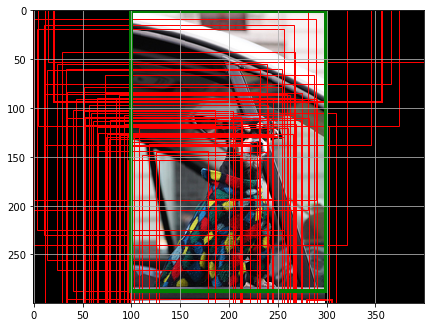

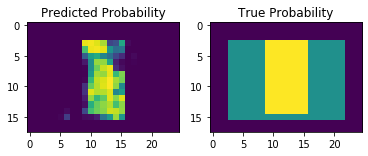

In [0]:
plot_test(reload_model, device,optimizer, criterion1, criterion2, dataloader_plot, 
         anchors[0], anchors[1])